In [1]:
!pip install torch-geometric
!pip install obonet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00


### Model and propagation layers
For propagation, currently this code uses a standard Graph Convolutional layer (GCN) rather than custom DAG layer which is used in GraphGOnet model. GCN layers simply aggregates information from nodes connections, whereas DAG layer aggregates in a leaf->node fashion.

In [193]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch.nn import Parameter, Linear
import numpy as np
#from torch_scatter import scatter_add

class GCNPropagation(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) propagation layer. - for aggregating the information in the ontology classes graph

    Args:
        in_channels (int): Number of input channels (node feature dimensionality).
        out_channels (int): Number of output channels (node feature dimensionality after propagation).
        aggr (str): Aggregation method for neighborhood information (default: 'mean').
    """

    def __init__(self, in_channels, out_channels, aggr="mean"):
        super(GCNPropagation, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        #self.conv2 = GCNConv(in_channels*8, out_channels)

    def forward(self, x, edge_index, batch=None):
        """
        Forward pass for the GCN propagation layer.

        Args:
            x (torch.Tensor): Node feature matrix of shape [num_nodes, in_channels].
            edge_index (torch.Tensor): Graph connectivity in COO format of shape [2, num_edges].
            batch (torch.Tensor): Batch indices for graph-level tasks (optional).

        Returns:
            torch.Tensor: Updated node features of shape [num_nodes, out_channels].
        """
        # Apply GCN convolution
        x = self.conv1(x, edge_index)
        # Apply ReLU activation
        x = F.relu(x)
        # x = self.conv2(x, edge_index)
        # # Apply ReLU activation
        # x = F.relu(x)

        return x

class OntologyNN(nn.Module):
    """
    PyTorch neural network model using tabular data and an ontology graph.
    This model integrates feature data with graph propagation through GNN layers.

    Args:
        n_features (int): Number of input features (e.g., F1, F3, F4, F5).
        n_nodes (int): Total number of nodes in the ontology graph (features + ontology terms).
        n_nodes_annot (int): Number of nodes with initial embeddings (features).
        n_nodes_emb (int): Number of nodes with embeddings after propagation.
        n_prop1 (int): Number of channels for the first propagation layer.
        adj_mat_fc1 (torch.Tensor): Adjacency matrix for feature-to-node connections.
        propagation (str): Propagation method for graph convolution (default: 'GCNConv').
    """

    def __init__(
        self,
        n_features,
        n_nodes,
        n_nodes_annot,
        n_nodes_emb,
        n_prop1,
        adj_mat_fc1,
        propagation="GCNPropagation",
        out_channels=1,
        out_activation=None,
        task='regression'
    ):
        super(OntologyNN, self).__init__()

        # Store the input parameters
        self.n_features = n_features
        self.n_nodes = n_nodes
        self.n_nodes_annot = n_nodes_annot
        self.n_nodes_emb = n_nodes_emb
        self.n_prop1 = n_prop1
        self.out_channels = out_channels
        self.out_activation = out_activation
        self.task = task

        # Convert adjacency matrix to a non-trainable torch tensor
        adj_mat_fc1 = torch.tensor(adj_mat_fc1, dtype=torch.float).t()
        self.adj_mat_fc1 = Parameter(adj_mat_fc1, requires_grad=False)

        # Define the first fully connected layer (feature to node mapping)
        self.fc1 = Linear(in_features=n_features, out_features=n_nodes_annot)

        # Apply the mask to the weights of the first layer
        with torch.no_grad():
            self.fc1.weight.mul_(self.adj_mat_fc1)

        self.relu = nn.ReLU()

        # Define the graph propagation layer
        self.propagation = eval(propagation)(
            in_channels=n_nodes_emb, out_channels=n_prop1
        )

        # Define the final fully connected layer for income prediction
        self.fc2 = Linear(in_features=n_prop1, out_features=out_channels)

    def forward(self, feature_data, graph_data):
        """Runs the forward pass of the module."""
        x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch

        # Initialize the node embeddings from the feature data using the fc1 layer
        initial_embedding = self.fc1(feature_data)

        #Added ReLU activation after fc1 layer
        x = self.relu(initial_embedding)

        # Perform graph propagation
        x = self.propagation(x, edge_index)

        # Aggregate node representations using global mean pooling
        #x = global_mean_pool(x, batch)

        # Predict income
        x = self.fc2(x)

        if self.task == 'classification':
          if self.out_channels == 1:
            #x = self.relu(x)
            x = torch.sigmoid(x)
          else:
            #x = self.relu(x)
            x = F.softmax(x, dim=1)
        elif self.task == 'regression':
            x = self.relu(x)
        if self.out_channels >=2:
          return x
        else:
          return x.view(-1)  # Return a 1D tensor of predictions

### Training on a toy dataset for regression - predicting income from other features

#### Ontology used: 3-high level classes: "Seniority", "Experience Level", "Qualification"

#### the features are linked to classes as follows:
Age -> Seniority,

Age -> Experience Level,

Education -> Qualification,

Experience -> Seniority,

Experience -> Experience level

#### and the classes are linked among themselves as:
"Seniority"->"Experience Level"

"Seniority"->"Qualification"

***Note that this is meant just for testing, this simple ontology may not make sense at all :D***

In [160]:
import pandas as pd

# Sample data
data = {
    'income': [50000, 60000, 70000, 80000, 90000],
    'age': [25, 30, 35, 40, 45],
    'education': [12, 16, 18, 20, 22],
    'experience': [2, 5, 8, 10, 12],
    'location': ['Urban', 'Suburban', 'Rural', 'Urban', 'Suburban']
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
df

,income,age,education,experience,location
0,50000,25,12,2,Urban
1,60000,30,16,5,Suburban
2,70000,35,18,8,Rural
3,80000,40,20,10,Urban
4,90000,45,22,12,Suburban


In [161]:
# prompt: label encode the location column

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder on the 'location' column
le.fit(df['location'])

# Transform the 'location' column
df['location'] = le.transform(df['location'])

# Print the updated DataFrame
df

,income,age,education,experience,location
0,50000,25,12,2,2
1,60000,30,16,5,1
2,70000,35,18,8,0
3,80000,40,20,10,2
4,90000,45,22,12,1


In [163]:
# prompt: create an ontology with three classes and define relationship with features through a matrix with shape (num_features*classes)

import numpy as np

# Define the ontology classes
classes = ["Seniority", "Experience Level", "Qualification"]

# Define the features
features = ["age", "education", "experience", "location"]

# Create the relationship matrix (num_features * num_classes)
relationship_matrix = np.zeros((len(features), len(classes)))

# Define the relationships between features and classes
# Example: Age is related to Seniority and Experience Level
relationship_matrix[0, 0] = 1  # Age -> Seniority
relationship_matrix[0, 1] = 1  # Age -> Experience Level
relationship_matrix[1,2] = 1 # Education -> Qualification
relationship_matrix[2, 0] = 1 # Experience -> Seniority
relationship_matrix[2, 1] = 1 # Experience -> Experience level
relationship_matrix[3, 0] = 1

relationship_matrix

array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 1., 0.],
       [1., 0., 0.]])

In [172]:
# model training
n_nodes = len(classes)
n_nodes_emb = len(classes)
n_features = len(features)
n_nodes_annot = len(classes)
n_prop1 = 16

feature_data = torch.Tensor(df[features].values)#torch.randn(3, n_features)  # 5 instances, 4 features
graph_data = Data(
    x=torch.ones(n_nodes, n_nodes_emb),  # Node features
    edge_index=torch.tensor([[0, 0], [1, 2]], dtype=torch.long),  # Edges
    batch=torch.tensor([0, 0, 0, 0, 0]),  # Batch index
)

# Create the model
model = OntologyNN(
    n_features=n_features,
    n_nodes=n_nodes,
    n_nodes_annot=n_nodes_annot,
    n_nodes_emb=n_nodes_emb,
    n_prop1=n_prop1,
    adj_mat_fc1=relationship_matrix,
    propagation="GCNPropagation",
)

# Define loss function and optimizer
criterion = torch.nn.MSELoss() # Example loss function, adjust as needed
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) # Example optimizer


all_loss = []
# Training loop
epochs = 1000
for epoch in range(epochs):
  optimizer.zero_grad()
  output = model(feature_data, graph_data)

  #Example target, replace with your actual target
  target = torch.Tensor(df['income'].values)
  loss = criterion(output, target)
  if epoch % 10 == 0:
    all_loss.append(loss.item())
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 50 == 0:
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

output

Epoch [50/1000], Loss: 3036381440.0000
Epoch [100/1000], Loss: 9034317.0000
Epoch [150/1000], Loss: 4680051.5000
Epoch [200/1000], Loss: 4629007.0000
Epoch [250/1000], Loss: 4584384.0000
Epoch [300/1000], Loss: 4541190.0000
Epoch [350/1000], Loss: 4500404.5000
Epoch [400/1000], Loss: 4462793.0000
Epoch [450/1000], Loss: 4428846.5000
Epoch [500/1000], Loss: 4398719.0000
Epoch [550/1000], Loss: 4372331.0000
Epoch [600/1000], Loss: 4349487.5000
Epoch [650/1000], Loss: 4329841.0000
Epoch [700/1000], Loss: 4313007.5000
Epoch [750/1000], Loss: 4298564.5000
Epoch [800/1000], Loss: 4286144.5000
Epoch [850/1000], Loss: 4275327.0000
Epoch [900/1000], Loss: 4265785.0000
Epoch [950/1000], Loss: 4257225.5000
Epoch [1000/1000], Loss: 4249391.0000


tensor([47663.5977, 63335.2031, 68091.0781, 80892.8516, 89527.3125],
       grad_fn=<ViewBackward0>)

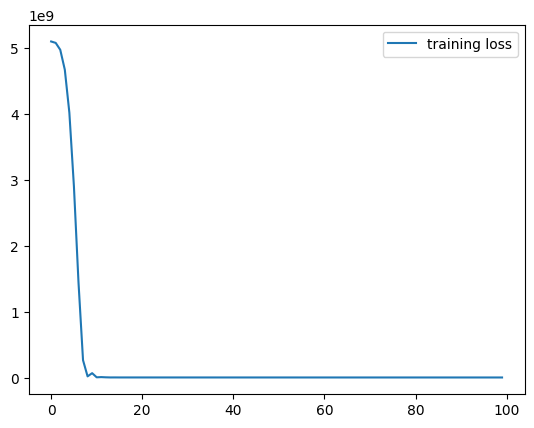

In [174]:
from matplotlib import pyplot as plt
plt.plot(all_loss, label='training loss')
plt.legend()

### Training on titanic data for classification task (predicting survival based on features)

ontology (class-feature mapping):

    'Demographics': ['Sex', 'Age', 'SibSp', 'Parch'],
    'Economic': ['Pclass', 'Fare'],
    'Location': ['Embarked']

where 'Demographics', 'Economic', 'Location' are classes

and these classes are linked as

'Demographics'-> 'Economic',

'Location' -> 'Economic',

'Economic' -> 'Location'


In [184]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load Titanic dataset
data = pd.read_csv("titanic.csv")

# Select relevant features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

# Handle missing values
data.dropna(inplace=True)

# Encode categorical variables
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
data['Embarked'] = le.fit_transform(data['Embarked'].astype(str))

# Scale numerical values
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,-0.372256,"Cumings, Mrs. John Bradley (Florence Briggs Th...",-1.039012,0.149065,0.833628,-0.631730,PC 17599,-0.097180,C85,-1.339397
3,4,1,-0.372256,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",-1.039012,-0.043230,0.833628,-0.631730,113803,-0.335997,C123,0.755557
6,7,0,-0.372256,"McCarthy, Mr. Timothy J",0.962453,1.174636,-0.723044,-0.631730,17463,-0.352250,E46,0.755557
10,11,1,3.520480,"Sandstrom, Miss. Marguerite Rut",-1.039012,-2.030273,0.833628,0.697081,PP 9549,-0.814070,G6,0.755557
11,12,1,-0.372256,"Bonnell, Miss. Elizabeth",-1.039012,1.431029,-0.723044,-0.631730,113783,-0.684702,C103,0.755557


In [185]:
# Map features to ontology nodes
ontology_mapping = {
    'Demographics': ['Sex', 'Age', 'SibSp', 'Parch'],
    'Economic': ['Pclass', 'Fare'],
    'Location': ['Embarked']
}

n_features = len(features)
classes = 3  # Adding 3 higher-level ontology nodes

adj_mat_fc1 = np.zeros((n_features, n_nodes))

# Assign connections
for i, feature in enumerate(features):
    if feature in ontology_mapping['Demographics']:
        adj_mat_fc1[i, 0] = 1  # Connect to Demographics
    elif feature in ontology_mapping['Economic']:
        adj_mat_fc1[i, 1] = 1  # Connect to Economic Status
    elif feature in ontology_mapping['Location']:
        adj_mat_fc1[i, 2] = 1  # Connect to Location

adj_mat_fc1

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Epoch [50/1000], Train Loss: 0.6638, Test Loss: 0.6711
Epoch [100/1000], Train Loss: 0.5962, Test Loss: 0.6256
Epoch [150/1000], Train Loss: 0.5499, Test Loss: 0.5899
Epoch [200/1000], Train Loss: 0.5222, Test Loss: 0.5658
Epoch [250/1000], Train Loss: 0.5051, Test Loss: 0.5532
Epoch [300/1000], Train Loss: 0.4954, Test Loss: 0.5499
Epoch [350/1000], Train Loss: 0.4858, Test Loss: 0.5538
Epoch [400/1000], Train Loss: 0.4779, Test Loss: 0.5613
Epoch [450/1000], Train Loss: 0.4734, Test Loss: 0.5597
Epoch [500/1000], Train Loss: 0.4705, Test Loss: 0.5554
Epoch [550/1000], Train Loss: 0.4686, Test Loss: 0.5525
Epoch [600/1000], Train Loss: 0.4609, Test Loss: 0.5429
Epoch [650/1000], Train Loss: 0.4584, Test Loss: 0.5377
Epoch [700/1000], Train Loss: 0.4560, Test Loss: 0.5325
Epoch [750/1000], Train Loss: 0.4537, Test Loss: 0.5301
Epoch [800/1000], Train Loss: 0.4518, Test Loss: 0.5300
Epoch [850/1000], Train Loss: 0.4502, Test Loss: 0.5301
Epoch [900/1000], Train Loss: 0.4487, Test Loss: 

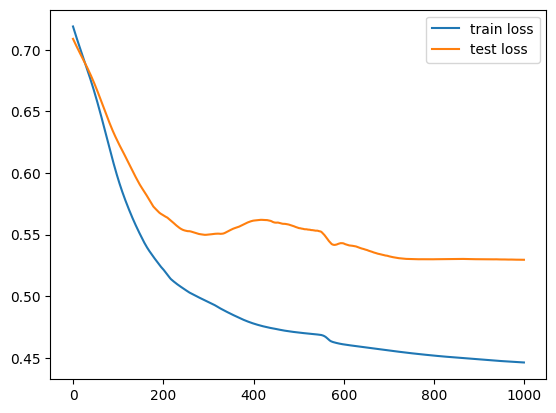

In [194]:
# training the model

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data['Survived'], test_size=0.2, random_state=42
)


# Example input data for train and test
n_nodes = len(ontology_mapping.keys())
n_nodes_emb = len(ontology_mapping.keys())
n_features = len(features)
n_nodes_annot = len(ontology_mapping.keys())
n_prop1 = 32

feature_data_train = torch.Tensor(X_train.values)
feature_data_test = torch.Tensor(X_test.values)

graph_data_train = Data(
    x=torch.ones(classes, n_nodes_emb),
    edge_index=torch.tensor([[0, 2, 1], [1, 1, 2]], dtype=torch.long),
    batch=torch.arange(len(X_train)),
)

graph_data_test = Data(
    x=torch.ones(classes, n_nodes_emb),
    edge_index=torch.tensor([[0, 2, 1], [1, 1, 2]], dtype=torch.long),
    batch=torch.arange(len(X_test)),
)

# Create the model
model = OntologyNN(
    n_features=n_features,
    n_nodes=n_nodes,
    n_nodes_annot=n_nodes_annot,
    n_nodes_emb=n_nodes_emb,
    n_prop1=n_prop1,
    adj_mat_fc1=adj_mat_fc1,
    propagation="GCNPropagation",
    out_channels=2,
    out_activation=None,
    task='classification'
)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

all_loss = []
train_losses = []
test_losses = []

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    output_train = model(feature_data_train, graph_data_train)
    target_train = torch.LongTensor(y_train.values)
    loss_train = criterion(output_train, target_train)
    loss_train.backward()
    optimizer.step()

    train_losses.append(loss_train.item())


    with torch.no_grad():
      output_test = model(feature_data_test, graph_data_test)
      target_test = torch.LongTensor(y_test.values)
      loss_test = criterion(output_test, target_test)
      test_losses.append(loss_test.item())


    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}')

plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "test loss")
plt.legend()
plt.show()

In [195]:
# prompt: print the accuracy of predictions for train and test set

from sklearn.metrics import accuracy_score

# Predictions on the training set
with torch.no_grad():
    train_predictions = model(feature_data_train, graph_data_train)
    train_predicted_labels = torch.argmax(train_predictions, dim=1)
    train_accuracy = accuracy_score(y_train, train_predicted_labels)
    print(f"Train Accuracy: {train_accuracy}")

# Predictions on the test set
with torch.no_grad():
    test_predictions = model(feature_data_test, graph_data_test)
    test_predicted_labels = torch.argmax(test_predictions, dim=1)
    test_accuracy = accuracy_score(y_test, test_predicted_labels)
    print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.8698630136986302
Test Accuracy: 0.7837837837837838


In [196]:
model

OntologyNN(
  (fc1): Linear(in_features=7, out_features=3, bias=True)
  (relu): ReLU()
  (propagation): GCNPropagation(
    (conv1): GCNConv(3, 32)
  )
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)